### Use CV to get HSV values - 2022 0119 CJH
---
* if you don't have it, get it with `pip install opencv-python`
* i added training photos to the training_images folder

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
import pandas as pd

### open and display an image with matplotlib

In [2]:
pwd

'C:\\CJH\\Python\\FRC\\FRC_training\\notebooks\\vision'

In [3]:
files = glob.glob('**/*.png*', recursive=True)
files

['training_images\\AVR_shooter.png',
 'training_images\\colors.png',
 'training_images\\home_shaded_red_blue.png',
 'training_images\\test_019.png',
 'training_images\\yellow_balls.png',
 'training_images\\avr_training\\selected_balls\\test_048.png',
 'training_images\\avr_training\\selected_balls\\test_054.png',
 'training_images\\avr_training\\selected_balls\\test_056.png',
 'training_images\\avr_training\\selected_balls\\test_077.png',
 'training_images\\avr_training\\selected_balls\\test_080.png',
 'training_images\\avr_training\\selected_balls\\test_092.png',
 'training_images\\avr_training\\selected_balls\\test_096.png',
 'training_images\\avr_training\\selected_balls\\test_097.png',
 'training_images\\avr_training\\selected_hub\\test_0004.png',
 'training_images\\avr_training\\selected_hub\\test_003.png',
 'training_images\\avr_training\\selected_hub\\test_0031.png',
 'training_images\\avr_training\\selected_hub\\test_004.png',
 'training_images\\avr_training\\selected_hub\\test

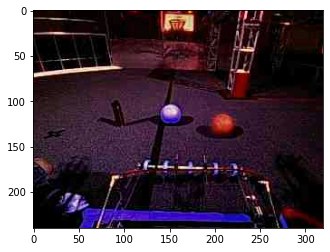

In [5]:
img = cv2.imread(files[2])   # Read the image as BGR
plt.imshow(img)   # Ploting the image using matplotlib

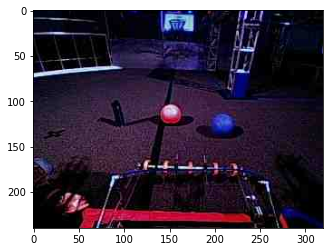

In [6]:
# convert to RGB color convention 
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

### RGB components

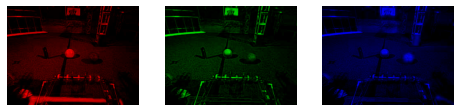

In [7]:
# look at the individual components in RGB space
fix, axs = plt.subplots(ncols=3, nrows=1, figsize=(8,3))
for ix, ax in enumerate(axs):
    temp = np.zeros(img_rgb.shape, dtype='uint8')
    temp[:,:,ix] = img_rgb[:,:,ix]
    ax.imshow(temp)
    ax.set_axis_off()
plt.show()

### HSV components  - note H goes to 180

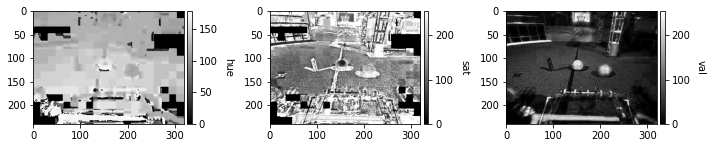

In [8]:
# look at them in HSV space
# look at the individual components in RGB space
img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(10,4))
divider = [None, None, None]
cax = [None, None, None]
cbar_legend = ['hue', 'sat', 'val']
cmap = 'gray'
for ix, ax in enumerate(axs):
    temp = np.zeros(img_hsv.shape[0:2], dtype='uint8')
    temp[:,:] = img_hsv[:,:,ix]
    im = ax.imshow(temp, cmap=cmap)
    divider[ix] = make_axes_locatable(ax)
    cax[ix] = divider[ix].append_axes("right", size="3%", pad=0.05)
    cb = plt.colorbar(im, cax=cax[ix])
    cb.ax.set_ylabel(cbar_legend[ix], rotation=270, labelpad=15)
    ax.imshow(temp, cmap=cmap)
fig.tight_layout()

### quick examination of the image - looking for blues (easy because HUE is ~107 )

In [9]:
height, width, _ = img_rgb.shape

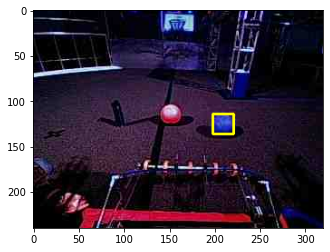

In [43]:
# cv has the origin at top left, and goes over in (x, y)
top_left_x = 198
top_left_y = 114  # x,y of the top left of the rectangle we want
width = 23
height = 22

rectangle_img = img_rgb.copy()
cv2.rectangle(rectangle_img, (top_left_x, top_left_y), (top_left_x+width, top_left_y+height), (255, 255, 0), 2)  # Rectangles: image, top left, bot right, color, thickness
plt.imshow(rectangle_img)

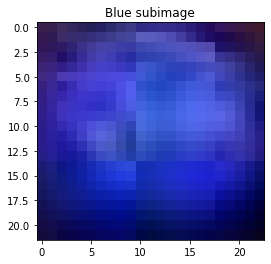

In [44]:
# numpy is not cv - origin is at the top left BUT it goes over in (y, x) 
sub_image_rgb = img_rgb[top_left_y:top_left_y+height, top_left_x:top_left_x+width,:]
sub_image_hsv =  img_hsv[top_left_y:top_left_y+height, top_left_x:top_left_x+width,:]
plt.title('Blue subimage')
plt.imshow(sub_image_rgb);


In [45]:
def analyze_data(img):
    results = {'AVG_RED':img[:,:,0].mean().round(2),
            'AVG_GREEN':img[:,:,1].mean().round(2),
            'AVG_BLUE':img[:,:,2].mean().round(2),
            'AVG_HUE':img[:,:,0].mean().round(2),
            'AVG_SAT':img[:,:,1].mean().round(2),
            'AVG_VAL':img[:,:,2].mean().round(2),
            'MAX_HUE':float(np.max(img[:,:,0])),
            'MIN_HUE':float(np.min(img[:,:,0])),
            'MAX_SAT':float(np.max(img[:,:,1])),
            'MIN_SAT':float(np.min(img[:,:,1])),
            'MAX_VAL':float(np.max(img[:,:,2])),
            'MIN_VAL':float(np.min(img[:,:,2]))}
    df = pd.DataFrame([results])
    pd.set_option("display.precision", 2)
    display(df)
    return results

In [46]:
training_data = analyze_data(sub_image_hsv)

,AVG_RED,AVG_GREEN,AVG_BLUE,AVG_HUE,AVG_SAT,AVG_VAL,MAX_HUE,MIN_HUE,MAX_SAT,MIN_SAT,MAX_VAL,MIN_VAL
0,119.5,197.44,157.42,119.5,197.44,157.42,165.0,112.0,255.0,132.0,238.0,30.0


In [29]:
def histogram_plot(data, save=False, title=''):
    # make a dataframe from the sub-image and add a cumulative density function (CDF)
    df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1],3), columns=['HUE', 'SAT', 'VAL'])
    df['hue_cdf'] = df.rank(method='average', pct=True)['HUE']
    df['sat_cdf'] = df.rank(method='average', pct=True)['SAT'] 
    df['val_cdf'] = df.rank(method='average', pct=True)['VAL'] 
    
    # set up a plot
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10,4))

    # three histograms - could do all this with a for loop but I'll be explicit for the students 
    ax1 = df.hist(column='HUE', bins=10, weights=np.ones(len(df)) / len(df), figsize = (10,6), ax=ax, color='purple', alpha=0.6)
    ax2 = df.hist(column='SAT', bins=20, weights=np.ones(len(df)) / len(df), figsize = (10,6), ax=ax, color='orange', alpha=0.6)
    ax3 = df.hist(column='VAL', bins=20, weights=np.ones(len(df)) / len(df), figsize = (10,6), ax=ax, color='cyan', alpha=0.6)
    # three cdfs
    ax4 = df.sort_values('HUE').plot(x ='HUE', y = 'hue_cdf', lw=3, style='--', ax=ax, fontsize=20, color='purple', alpha=0.6)
    ax4 = df.sort_values('SAT').plot(x ='SAT', y = 'sat_cdf', lw=3, style='--', ax=ax, fontsize=20, color='orange', alpha=0.6)
    ax4 = df.sort_values('VAL').plot(x ='VAL', y = 'val_cdf', lw=3, style='--', grid = True, ax=ax, fontsize=20, color='cyan', alpha=0.6)
    # annotate the plot
    plt.legend(loc=(0.95,0.5), prop={'size': 14})
    plt.title(f'{title} HSV Histogram, n={len(df)}', fontsize=16)
    plt.xlabel(f'Value of H, S, or V', fontsize=18)
    if save:
        plt.savefig('training_histogram.png', facecolor='w')
    plt.show()

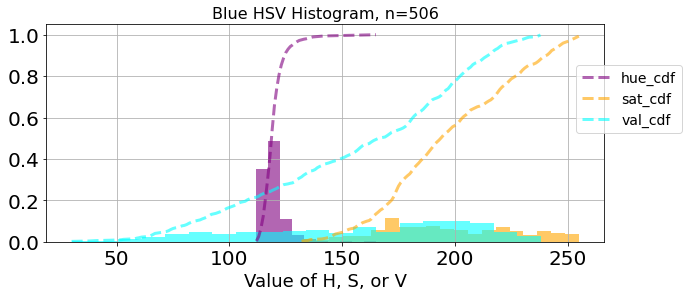

In [30]:
histogram_plot(sub_image_hsv, title='Blue', save=False)

#### see how it worked - not much guesswork anymore...

In [47]:
def hsv_threshold(input, hue, sat, val):
    """Segment an image based on hue, saturation, and value ranges.
    Args:
        input: A BGR numpy.ndarray.
        hue: A list of two numbers the are the min and max hue.
        sat: A list of two numbers the are the min and max saturation.
        lum: A list of two numbers the are the min and max value.
    Returns:
        A black and white numpy.ndarray.
    """
    out = cv2.cvtColor(input, cv2.COLOR_RGB2HSV)
    return cv2.inRange(out, (hue[0], sat[0], val[0]), (hue[1], sat[1], val[1]))

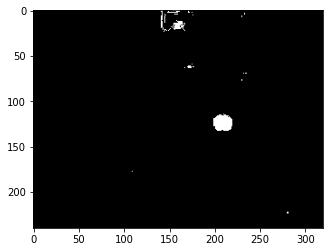

In [71]:
hue_tolerance = 5
h = [110,135]
s = [140,255]
v = [140,250]
hsv_thresh_image = hsv_threshold(img_rgb.copy(), h, s, v)
plt.imshow(hsv_thresh_image, cmap='gray')

### what works at OC???

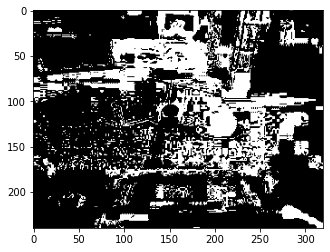

In [72]:
hue_tolerance = 5
h = [training_data['MIN_HUE'] - hue_tolerance, training_data['MAX_HUE'] + hue_tolerance]
s = [training_data['MIN_SAT'], training_data['MAX_SAT']]
v = [training_data['MIN_VAL'], training_data['MAX_VAL']]
hsv_thresh_image = hsv_threshold(img_rgb.copy(), h, s, v)
plt.imshow(hsv_thresh_image, cmap='gray')

### fix the problems with red - it wraps around 180, so it makes life harder
* can just do two cv.inRange() calls, but that's several if statements
* or you can invert the image (color negative) and look for cyan (hue ~ 90)

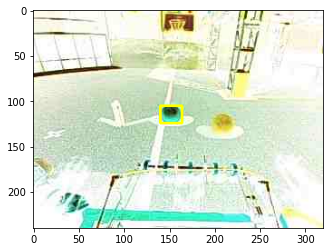

In [81]:
# invert an image - red becomes cyan
top_left_x = 140
top_left_y = 105  # x,y of the top left of the rectangle we want
width = 24
height = 19

rectangle_img = ~img_rgb.copy()
cv2.rectangle(rectangle_img, (top_left_x, top_left_y), (top_left_x+width, top_left_y+height), (255, 255, 0), 2)  # Rectangles: image, top left, bot right, color, thickness
plt.imshow(rectangle_img)

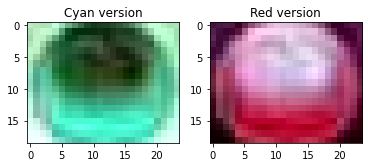

In [82]:
# numpy is not cv - origin is at the top left BUT it goes over in (y, x) 
sub_image_rgb = img_rgb[top_left_y:top_left_y+height, top_left_x:top_left_x+width,:]
sub_image_not_rgb = ~img_rgb[top_left_y:top_left_y+height, top_left_x:top_left_x+width,:]
sub_image_not_hsv = cv2.cvtColor(sub_image_not_rgb, cv2.COLOR_RGB2HSV)
sub_image_hsv = cv2.cvtColor(sub_image_rgb, cv2.COLOR_RGB2HSV)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title('Cyan version')
ax1.imshow(sub_image_not_rgb)
ax2.set_title('Red version')
ax2.imshow(sub_image_rgb)

In [83]:
training_data_cyan = analyze_data(sub_image_not_hsv)

,AVG_RED,AVG_GREEN,AVG_BLUE,AVG_HUE,AVG_SAT,AVG_VAL,MAX_HUE,MIN_HUE,MAX_SAT,MIN_SAT,MAX_VAL,MIN_VAL
0,71.78,130.89,166.7,71.78,130.89,166.7,90.0,39.0,255.0,13.0,255.0,29.0


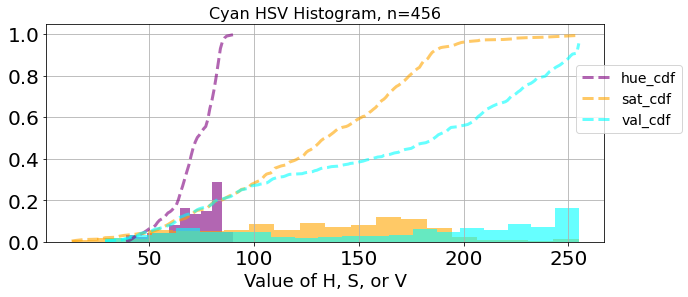

In [84]:
histogram_plot(sub_image_not_hsv, title='Cyan', save=False)

In [85]:
training_data_red = analyze_data(sub_image_hsv)

,AVG_RED,AVG_GREEN,AVG_BLUE,AVG_HUE,AVG_SAT,AVG_VAL,MAX_HUE,MIN_HUE,MAX_SAT,MIN_SAT,MAX_VAL,MIN_VAL
0,160.21,139.48,169.52,160.21,139.48,169.52,177.0,0.0,255.0,22.0,255.0,13.0


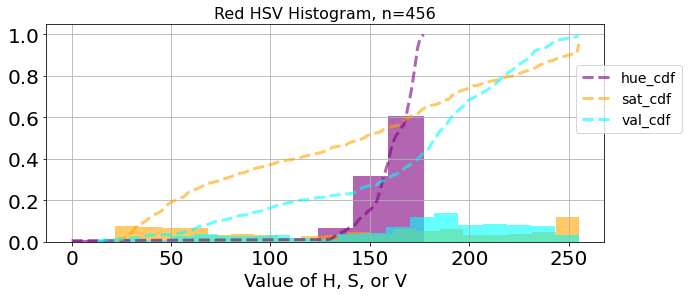

In [86]:
histogram_plot(sub_image_hsv, title='Red', save=False)

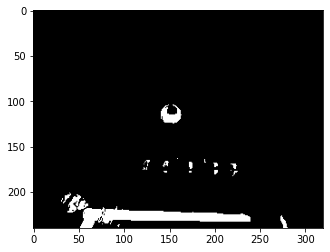

In [120]:
h = [150,180]
h2 = h1
s = [50,255]
v = [120,254]
hsv_thresh_image = hsv_threshold(img_rgb.copy(), h, s, v) + hsv_threshold(img_rgb.copy(), h2, s, v)
plt.imshow(hsv_thresh_image, cmap='gray')

#### if cyan is impractical, just use an OR statement in your HSV threshold

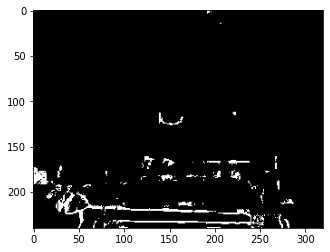

In [41]:
h1 = 0, 10
h2 = 170, 180
s = [training_data_red['MIN_SAT'], training_data_red['MAX_SAT']]
v = [training_data_red['MIN_VAL'], training_data_red['MAX_VAL']]
hsv_thresh_image = hsv_threshold(img_rgb.copy(), h1, s, v) | hsv_threshold(img_rgb.copy(), h2, s, v)
plt.imshow(hsv_thresh_image, cmap='gray')